# Simulação de Monte Carlo (Monte Carlo Simulation)
Avalia cenários de emissão de CO2 com diferentes quantidades de ônibus a diesel em operação. Para os demais poluentes, será o mesmo processo.

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.manual_data import manual_data_path

In [2]:
#Carregar Dados
onibus_diesel_dia31= pd.read_csv(manual_data_path('calculo-emissao-poluentes-diario_2025-12-31_silver.csv'))

#### PT-BR
A Simulação de Monte Carlo é feita levando em consideração um dataframe (`df_diesel`), sendo que a frota total considerada para a simulação é a quantidade de observações desse dataframe (equivalente a um `frota_total = len(df_diesel)`). Dessa frota, uma quantidade `n` (`n= Y`) de ônibus aleatórios serão convertidos de diesel para elétricos (`amostra`). A simulação é repetida uma quantidade `N` de vezes, resultado em um valor das emissões evitadas por dia (`resultados_diarios`) e ao longo de um ano (`resultados_acumulados`). Nota-se que calcular a emissão evitada de um ônibus elétrico, é o mesmo que calcular a emissão desse ônibus caso fosse a diesel. Os resultados finais da Simulação de Monte Carlo são definidos por uma média dos valores resultantes de todas as simulações realizadas.
#### ENG
Our Monte Carlo Simulation is done considering a dataframe (`df_diesel`), and tht total bus fleet considered is the lenght of that dataframe (it would be `frota_total = len(df_diesel)`). This fleet has a number of `n` (`n= Y`) random buses that will be converted from diesel to electric (`amostra`). The simulation repeats itself a `N` number of timer, resulting the value of the avoided emitions daily (`resultados_diarios`) and annually (`resultados_acumulados`). Note that the calculating the avoided emition fo an electric bus is the sames as calculation the emition of the bus if it was a diesel bus. The final results of the Monte Carlo Simulation are defined by the mean of the resultant values of the N simulations done.


In [3]:
def sim_monte_carlo(df_diesel, 
                    Y, #ônibus elétricos
                    N=2000, 
                    dias=365):
    
    resultados_diarios = []

    for _ in range(N):
        amostra = df_diesel.sample(
            n=Y, 
            replace=False
        )
        emissao_total = amostra["emissao_co2"].sum()
        resultados_diarios.append(emissao_total)

    resultados_diarios = np.array(resultados_diarios)
    resultados_acumulados = resultados_diarios * dias

    impacto_medio = resultados_diarios.mean()
    impacto_maximo = (
        df_diesel
        .nlargest(Y, "emissao_co2")
        ["emissao_co2"]
        .sum()
    )
    impacto_diferenca = impacto_maximo - impacto_medio

    #intervalos de confiança
    IC_inf = np.percentile(resultados_diarios, 2.5)
    IC_sup = np.percentile(resultados_diarios, 97.5)

    return {
        "onibus_eletricos": Y,
        "dias": dias,
        "impacto_medio_dia": impacto_medio,
        "IC_inf_dia": IC_inf,
        "IC_sup_dia": IC_sup,
        "impacto_maximo_dia": impacto_maximo,
        "impacto_diferenca_dia": impacto_diferenca,
        "impacto_medio_acumulado": resultados_acumulados.mean(),
        "IC_inf_acumulado": np.percentile(resultados_acumulados, 2.5),
        "IC_sup_acumulado": np.percentile(resultados_acumulados, 97.5),
        "total_emissao_dia": resultados_diarios,
        "total_emissao_acumulados": resultados_acumulados
    }

#### PT-BR
Para estimar a frota de ônibus elétricos necessários para cumprir a meta de emissão, usamos a função `estimar_frota_para_meta`, em que a meta é `meta_emissao` e a frota total é, novamente, o número de observações do dataframe (`frota_total = len(df_diesel)`). Essa função chama a função da Simulação de Monte Carlo (`sim_monte_carlo()`) para diferentes valores de ônibus elétricos (`Y`), em ordem crescente, da menor quantidade de ônibus elétricos (`Y_min`) à maior (`Y_max`). Cada vez que uma nova simulação é chamada, o número `Y` de ônibus elétricos aumenta em uma quantidade `passo` e quando a meta é batida, a função para e retorna os resultados finais.
#### ENG
To estimate the fleet of electric buses needed to meeat a goal of avoided emition, we use the function `estimar_frota_para_meta`, where the goal is `meta_emissao` and the total fleet is again the lenght of the dataframe (`frota_total = len(df_diesel)`). This function calls the Monte Carlo Simulation function (`sim_monte_carlo`) for different values of electric buses (`Y`), in an increasing range, from the lowest number of electric buses (`Y_min`) to the highest (`Y_max`). Each time a new simulation is called, the `Y` number of electric buses increases in a `passo` amount and when the goal is met, the fuction stops and returns the final values.

In [4]:
def estimar_frota_para_meta(
    df_diesel,
    meta_emissao,
    N=2000, #número de simulações
    Y_min=10, #qtd minima de onibus substituidos por elétricos
    Y_max=500, #qtdd máxima de onibus substituidos por elétricos
    passo=100
):

    resultados_meta = []

    for Y in range(Y_min, Y_max + 1, passo):
        sim = sim_monte_carlo(df_diesel, Y, N=N)

        valor = sim["impacto_medio_dia"]

        resultados_meta.append({
            "e_bus": Y,
            "mean_estimated_impact": valor
        })

        if valor >= meta_emissao:
            break

    return pd.DataFrame(resultados_meta)

In [5]:
meta = 1000 
#goal = 1000 Kg of emited CO2 (or a ton)

df_meta = estimar_frota_para_meta(
    onibus_diesel_dia31,
    meta_emissao=meta
)

display(df_meta.tail()) 

,e_bus,mean_estimated_impact
0,10,2595.948071


In [6]:
tamanhos_frota = [50, 100, 200]
dias_projecao = 365

res = [
    sim_monte_carlo(onibus_diesel_dia31, y, dias=dias_projecao)
    for y in tamanhos_frota
]

In [7]:
tabela_resumo = pd.DataFrame([
    {
        "Electric Bus": r["onibus_eletricos"],
        "Mean Avoided Emition (t CO2/day)": r["impacto_medio_dia"]/1000,
        "IC95% inf (day)": r["IC_inf_dia"], #Confidence Interval
        "IC95% sup (day)": r["IC_sup_dia"], #Confidence Interval
        "Max Scenery (t CO2/day)": r["impacto_maximo_dia"]/1000,
        "Mean Accumulated Emition (t CO2)": r["impacto_medio_acumulado"]/1000
    }
    for r in res
]).round(4)

display(tabela_resumo)

,Electric Bus,Mean Avoided Emition (t CO2/day),IC95% inf (day),IC95% sup (day),Max Scenery (t CO2/day),Mean Accumulated Emition (t CO2)
0,50,12.8602,9896.6414,16240.0781,78.6430,4693.9891
1,100,25.7548,21330.7137,30695.8222,128.1478,9400.5169
2,200,51.6593,45336.6115,62248.1600,212.8397,18855.6356


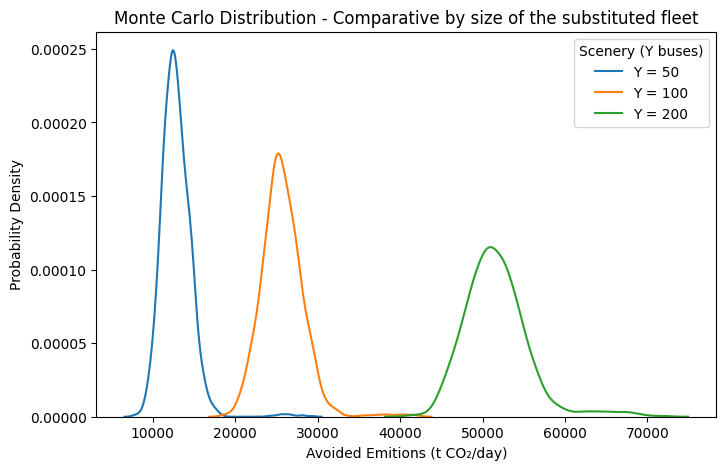

In [8]:
plt.figure(figsize=(8,5))
for r in res:
    sns.kdeplot(
        r["total_emissao_dia"],
        label=f"Y = {r['onibus_eletricos']}"
    )

plt.xlabel("Avoided Emitions (t CO₂/day)")
plt.ylabel("Probability Density")
plt.title("Monte Carlo Distribution - Comparative by size of the substituted fleet")
plt.legend(title="Scenery (Y buses)")
plt.show()